In [1]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d manjilkarki/deepfake-and-real-images
!unzip -q deepfake-and-real-images.zip -d deepfake_dataset


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images
License(s): unknown
100% 1.68G/1.68G [01:16<00:00, 24.4MB/s]
100% 1.68G/1.68G [01:16<00:00, 23.5MB/s]


In [2]:
import os
import matplotlib.pyplot as plt
import cv2

dataset_path = "/content/deepfake_dataset/Dataset/Train"


print("Folders inside dataset:", os.listdir(dataset_path))

real_folder = "REAL" if "REAL" in os.listdir(dataset_path) else "Real"
fake_folder = "FAKE" if "FAKE" in os.listdir(dataset_path) else "Fake"

real_images = os.listdir(os.path.join(dataset_path, real_folder))
fake_images = os.listdir(os.path.join(dataset_path, fake_folder))



Folders inside dataset: ['Fake', 'Real']


In [3]:
import numpy as np
real_images_shape = np.array(real_images).shape
print(real_images_shape)

(70001,)


In [4]:
import numpy as np
fake_images_shape = np.array(fake_images).shape
print(fake_images_shape)

(70001,)


Sample Real Image:


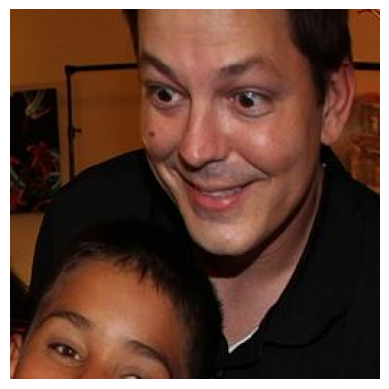

Sample Fake Image:


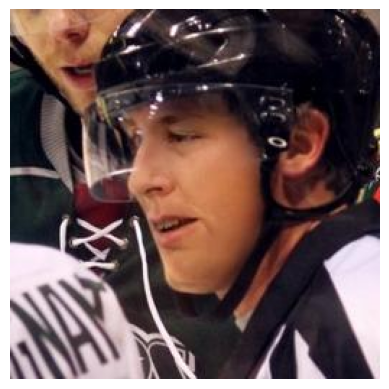

In [5]:

def show_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

print("Sample Real Image:")
show_image(os.path.join(dataset_path, real_folder, real_images[2]))

print("Sample Fake Image:")
show_image(os.path.join(dataset_path, fake_folder, fake_images[2]))

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from transformers import SwinForImageClassification
from peft import LoraConfig, get_peft_model
from torchvision import datasets, transforms
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset_path = "/content/deepfake_dataset/Dataset/Train"

dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
dataset_size = len(dataset)


num_samples = min(6000, dataset_size)
sampled_indices = random.sample(range(dataset_size), num_samples)
sampled_dataset = Subset(dataset, sampled_indices)


train_size = int(0.8 * len(sampled_dataset))
val_size = len(sampled_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(sampled_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")


class SwinDeepfakeDetector(nn.Module):
    def __init__(self, num_classes=2, model_name="microsoft/swin-base-patch4-window7-224"):
        super(SwinDeepfakeDetector, self).__init__()


        self.swin = SwinForImageClassification.from_pretrained(model_name,
            num_labels=num_classes,
            ignore_mismatched_sizes=True
)


        lora_config = LoraConfig(
            r=8,
            lora_alpha=16,
            target_modules=["query", "key", "value"],
            lora_dropout=0.05,
            bias="none"
        )

        self.swin = get_peft_model(self.swin, lora_config)

    def forward(self, x):
        return self.swin(x).logits

model = SwinDeepfakeDetector(num_classes=2).to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    avg_loss = running_loss / len(train_loader.dataset)


    model.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

torch.save(model.state_dict(), "swin_deepfake_lora.pth")
print("Model saved successfully!")


Train size: 4800, Val size: 1200


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/352M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5] - Train Loss: 0.6687, Val Loss: 0.5797, Val Acc: 0.7142
Epoch [2/5] - Train Loss: 0.3739, Val Loss: 0.2162, Val Acc: 0.9150
Epoch [3/5] - Train Loss: 0.1915, Val Loss: 0.1378, Val Acc: 0.9475
Epoch [4/5] - Train Loss: 0.1427, Val Loss: 0.1055, Val Acc: 0.9625
Epoch [5/5] - Train Loss: 0.1232, Val Loss: 0.1118, Val Acc: 0.9583
Model saved successfully!


In [8]:
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinDeepfakeDetector(num_classes=2).to(device)

model.load_state_dict(torch.load("swin_deepfake_lora.pth"))
model.eval()


criterion = nn.CrossEntropyLoss()
val_loss, correct, total = 0.0, 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)


        outputs = model(images)
        loss = criterion(outputs, labels)

        val_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        correct += (preds == labels).sum().item()
        total += labels.size(0)

val_loss /= len(val_loader.dataset)
val_accuracy = correct / total

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

print(classification_report(all_labels, all_preds, target_names=["Real", "Fake"]))

conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", conf_matrix)


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-8-e3316e895bf8>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped 

Validation Loss: 0.1072
Validation Accuracy: 0.9600
              precision    recall  f1-score   support

        Real       0.97      0.95      0.96       593
        Fake       0.95      0.97      0.96       607

    accuracy                           0.96      1200
   macro avg       0.96      0.96      0.96      1200
weighted avg       0.96      0.96      0.96      1200

Confusion Matrix:
 [[563  30]
 [ 18 589]]
